### Codigo para la propagación de onda acustica 1D con fuente y sin perturbación inicial en un medio heterogeneo
En este Notebook se presenta un codigo para la propagación de onda acustica 1D con fuente sin perturbación inicial en medio heterogeneo con bordes fijos, se muestran el gráfico de la función fuente, el modelo de velocidades del intervalo de simulación y los sismogramas resultantes de dos receptores que estan ubicados en x = 120 m y x = 240 m.

#### Solución numérica de la Ecuación de Onda Acustica (método de diferencias finitas)
La ecuación de onda acústica en 1D con densidad constante con fuente es:

$$
\partial^2_t p(x,t) \ = \ c(x)^2 \partial_x^2 p(x,t) + s(x,t)
$$

con presión $p$, la velocidad de propagación $c$ y el termino fuente $s$, la cual contiene dos derivadas parciales segundas que se pueden aproximar con la fórmula de diferencia centrada de la siguiente manera:

- Segunda derivada temporal
$$
\partial^2_t p(x,t) \ \approx \ \frac{p(x,t+dt) - 2 p(x,t) + p(x,t-dt)}{dt^2} 
$$
- Segunda derivada espacial
$$
\partial^2_x p(x,t) \ \approx \ \frac{p(x+dx,t) - 2 p(x,t) + p(x-dt,t)}{dx^2} 
$$

Al utilizar estas aproximaciones en la ecuación de onda nos permite formular la presión $p(x)$ para el paso de tiempo $𝑡 + 𝑑𝑡$ (el futuro) en función de la presión en el tiempo $𝑡$ (ahora) y $𝑡 − 𝑑𝑡$ (el pasado). Esto se llama un esquema explícito que permite que el 𝑒𝑥𝑡𝑟𝑎𝑝𝑜𝑙𝑎c𝑖ó𝑛 del campo dependiente del espacio en el futuro solo usando el vecindario los puntos vecinos.

Reemplazamos la parte dependiente del tiempo (tiempo es índice superior, espacio es índice inferior) por:

$$
 \frac{p_{i}^{n+1} - 2 p_{i}^n + p_{i}^{n-1}}{dt^2} \ = \ c^2_i \left(\frac{p_{i+1}^{n} - 2 p_{i}^n + p_{i-1}^{n}}{dx^2}\right) + s_i^n 
$$

resolviendo por $p_{i}^{n + 1}$.

El esquema de extrapolación es:

$$
p_{i}^{n+1} \ = \ c_i^2 \frac{dt^2}{dx^2} \left[p_{i+1}^{n} - 2 p_{i}^n + p_{i-1}^{n} \right]
+ 2p_{i}^n - p_{i}^{n-1} + s_i^n dt^2 
$$

#### Estabilidad (Criterio de Courant)

Ahora, presentamos el parámetro epsilon $\epsilon$ conocido como el criterio de Courant, el cual nos permite determinar numéricamente el límite de estabilidad del código con la mayor precisión posible aumentando el paso de tiempo.

El criterio de Courant se define como:

$$
\epsilon = c \frac{ dt}{dx} \leq 1
$$

Con esta información podemos calcular el paso de tiempo máximo posible y estable.

#### Termino o función fuente

En este codigo se uso como función fuente la primera derivada de una función gaussiana cuya ecuación es:

$$
s  = -2. * (t - t_0) * f_0^2 * exp[-1.0 * (f_0^2) * (t - t_0)^2]
$$

donde $f_0$ es la frecuencia dominante y $t_0$ es el retraso en tiempo

#### Modelo de velocidad

Se utilizo un modelo de velocidad que esta compuesto por dos estratos el primero donde la velocidad de propagación es de 100 m/s y el segundo cuya velocidad es 333 m/s.

#### Sismogramas

Se simulo tener dos sensores o receptores que estan ubicados en x = 120 m y x = 240 m. El gráfico de la señal registrada en los receptores se muestra al final del Notebook

In [25]:
# This program describes a moving 1-D wave using the finite difference method
# Import Libraries
# ----------------------------------------------
import numpy as np
import matplotlib
# Show Plot in The Notebook
matplotlib.use("nbagg")
import matplotlib.pyplot as plt

# Sub-plot Configuration
# ----------------------
from matplotlib import gridspec 

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

In [26]:
# Parameter Configuration 
# -----------------------

nx   = 1000         # number of grid points in x-direction
dx   = 0.4          # grid point distance in x-direction
c0   = 333.         # wave speed in medium (m/s)
isrc = 100          # source location in grid in x-direction
ir1  = 300          # receiver location 1 in grid in x-direction
ir2  = 600          # receiver location 2 in grid in x-direction
nt   = 3001         # maximum number of time steps
dt   = 0.0010       # time step

# Velocity model 
# ---------------
c=np.zeros(nx)
for n in range(0,500):
    c[n]=100
    c[n+500]=333

# CFL Stability Criterion
# -----------------------
eps  = c0 * dt / dx # epsilon value

print('Stability criterion =', eps)

Stability criterion = 0.8325


<IPython.core.display.Javascript object>


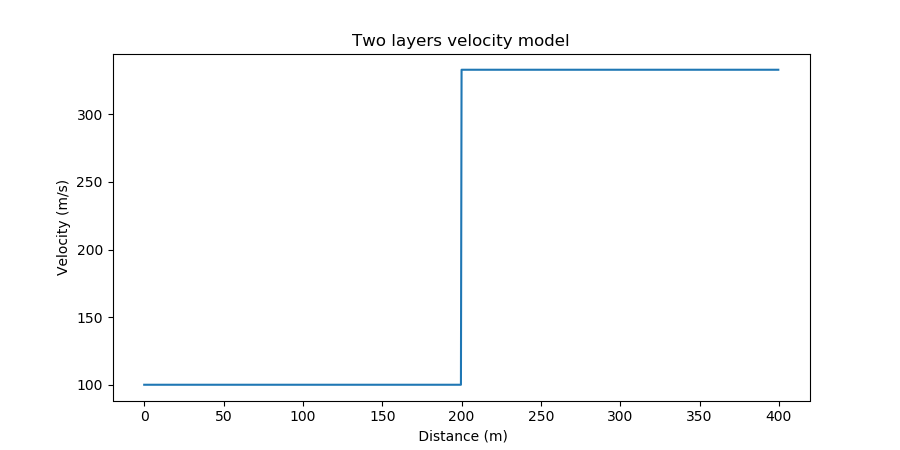

In [27]:
# Initialize coordinate
# ---------------------
x    = np.arange(nx)
x    = x * dx       # coordinate in x-direction

# Plot velocity model 
# ---------------
plt.ion()
fig3 = plt.figure(figsize=(9,4.5))
plt.plot(x, c)
plt.title('Two layers velocity model')
plt.xlabel(' Distance (m)')
plt.ylabel('Velocity (m/s)')
plt.show()

Source frequency = 25.0 Hz


<IPython.core.display.Javascript object>


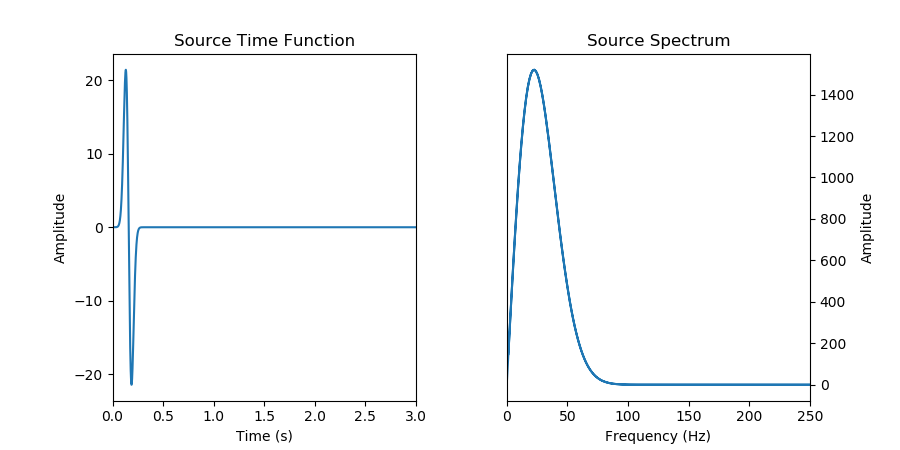

In [28]:
# Plot Source Time Function 
# -------------------------

f0   = 25. # dominant frequency of the source (Hz)
t0   = 4. / f0 # source time shift
print('Source frequency =', f0, 'Hz')

# Source time function (Gaussian)
# -------------------------------
src  = np.zeros(nt + 1)
time = np.linspace(0 * dt, nt * dt, nt)
# 1st derivative of a Gaussian
src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(-1.0 * (f0 ** 2) * (time - t0) ** 2))

# Plot position configuration
# ---------------------------
plt.ion()
fig1 = plt.figure(figsize=(9, 4.5))
gs1  = gridspec.GridSpec(1, 2, width_ratios=[1, 1], hspace=0.3, wspace=0.3)

# Plot source time function
# -------------------------
ax1  = plt.subplot(gs1[0])
ax1.plot(time, src) # plot source time function
ax1.set_title('Source Time Function')
ax1.set_xlim(time[0], time[-1])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')

# Plot source spectrum
# --------------------
ax2  = plt.subplot(gs1[1])
spec = np.fft.fft(src) # source time function in frequency domain
freq = np.fft.fftfreq(spec.size, d = dt / 4.) # time domain to frequency domain
ax2.plot(np.abs(freq), np.abs(spec)) # plot frequency and amplitude
ax2.set_xlim(0, 250) # only display frequency from 0 to 250 Hz
ax2.set_title('Source Spectrum')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

plt.show()

<IPython.core.display.Javascript object>


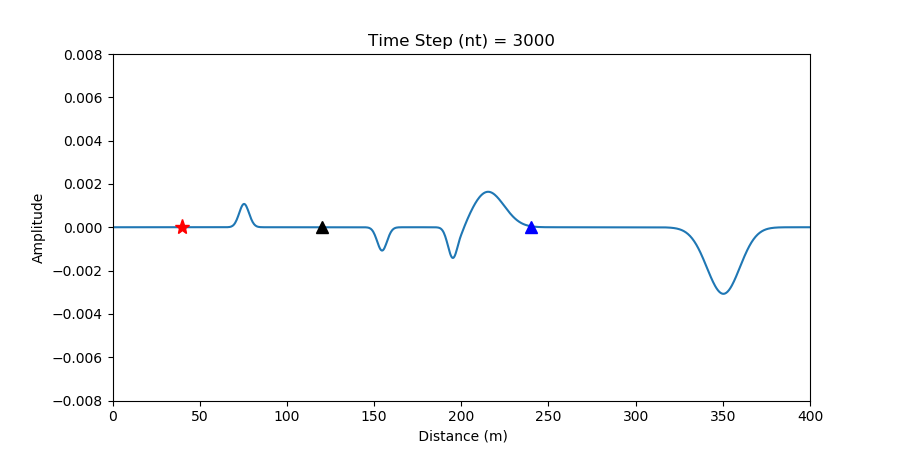

5 - point operator


In [29]:
# 1D Wave Propagation (Finite Difference Solution) 
# ------------------------------------------------
# Initialize empty pressure
# -------------------------
p    = np.zeros(nx) # p at time n (now)
pold = np.zeros(nx) # p at time n-1 (past)
pnew = np.zeros(nx) # p at time n+1 (present)
d2px = np.zeros(nx) # 2nd space derivative of p

# Initialize model (assume homogeneous model)
# -------------------------------------------
#c    = np.zeros(nx)
#c    = c + c0       # initialize wave velocity in model

# Initialize coordinate
# ---------------------
x    = np.arange(nx)
x    = x * dx       # coordinate in x-direction

# Initialize empty seismogram
# ---------------------------
seis = np.zeros((nt,2))

# First set up the figure, the axis, and the plot element we want to animate
fig2 = plt.figure(figsize=(9,4.5))
ax = plt.axes(xlim=(0, 400), ylim=(-0.008, 0.008))
up31,= plt.plot(x,p) # plot pressure update each time step
leg1,= ax.plot(isrc*dx, 0, 'r*', markersize=11) # plot position of the source in snapshot
leg2,= ax.plot(ir1*dx, 0, 'k^', markersize=8) # plot position of the receiver 1 in snapshot
leg2,= ax.plot(ir2*dx, 0, 'b^', markersize=8) # plot position of the receiver 2 in snapshot
ax.set_title('1D wave propagation')
ax.set_xlabel(' Distance (m)')
ax.set_ylabel('Amplitude')
plt.show()

u=np.zeros((nx,nt))
# FD Point Operator (choose 3 or 5 point operator)
# ------------------------------------------------
op   = 5
print(op, '- point operator')

# Calculate Partial Derivatives
# -----------------------------
for it in range(nt):
    if op==3: # use 3 point operator FD scheme
        for i in range(1, nx - 1):
            d2px[i] = (p[i + 1] - 2 * p[i] + p[i - 1]) / dx ** 2

    if op==5: # use 5 point operator FD scheme
        for i in range(2, nx - 2):
            d2px[i] = (-1./12 * p[i + 2] + 4./3  * p[i + 1] - 5./2 * p[i]+4./3  * p[i - 1] - 1./12 * p[i - 2]) / dx ** 2

    # Time Extrapolation
    # ------------------
    pnew = 2 * p - pold + c ** 2 * dt ** 2 * d2px

    # Add Source Term at isrc
    # -----------------------
    pnew[isrc] = pnew[isrc] + src[it] * dt ** 2
    
            
    # Remap Time Levels
    # -----------------
#    pold, p = p, pnew
    pold=p
    p=pnew
    
    u[:,it]=p
    # Output Seismogram
    # -----------------
    seis[it,0] = p[ir1]
    seis[it,1] = p[ir2]

    idisp = 10 # display frequency
    if (it % idisp) == 0:
        plt.title('Time Step (nt) = %d' % it)
        up31.set_ydata(p)
        plt.gcf().canvas.draw()
plt.close()

<IPython.core.display.Javascript object>


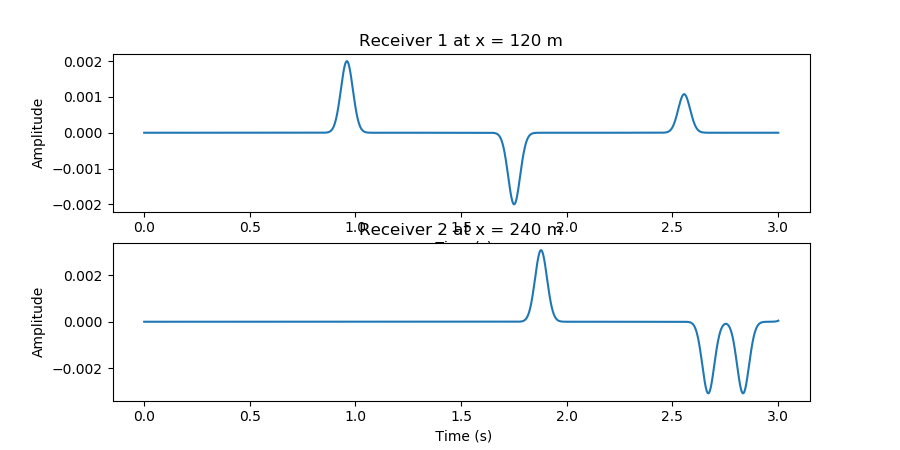

In [30]:
# == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == ==
# Plot the results
# == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == ==
        
# Plot seismogram 
# ---------------
plt.ion()
fig3 = plt.figure(figsize=(9,4.5))
plt.subplot(211)
plt.plot(time, seis[:,0])
plt.title('Receiver 1 at x = 120 m')
plt.ylabel('Amplitude')
plt.xlabel(' Time (s)')
plt.subplot(212)
plt.plot(time, seis[:,1])
plt.title('Receiver 2 at x = 240 m')
plt.xlabel(' Time (s)')
plt.ylabel('Amplitude')
plt.show()